In [1]:
import sys
sys.path.append('..')
from src.utilities import *

# 4. Cluster Analysis

### 4.1 Store individual exhibits

In [16]:
master = pd.read_csv(os.path.join(processed_path, 'master.csv'))

model_01 = pd.read_pickle(os.path.join(models_path, 'model2_quantile_0.1.pkl'))
model_05 =  pd.read_pickle(os.path.join(models_path, 'model2_quantile_0.5.pkl'))
model_09 =  pd.read_pickle(os.path.join(models_path, 'model2_quantile_0.9.pkl'))

master['preds_01'] = model_01.predict(master.drop(columns = ['month', 'region', 'brand', 'sales']))
master['preds_05'] = model_05.predict(master.drop(columns = ['month', 'region', 'brand', 'sales', 'preds_01']))
master['preds_09'] = model_09.predict(master.drop(columns = ['month', 'region', 'brand', 'sales', 'preds_01', 'preds_05']))

master = master[['month', 'region', 'brand', 'sales', 'preds_01', 'preds_05', 'preds_09']]
master.to_excel(os.path.join(results_path, 'individual_exhibits.xlsx'))
master.head()

,month,region,brand,sales,preds_01,preds_05,preds_09
0,2020-01,region_0,brand_1,0.0,0.0,0.247937,657.331908
1,2020-01,region_0,brand_2,0.0,0.0,0.247937,657.331908
2,2020-01,region_1,brand_1,0.0,0.0,0.247937,305.698907
3,2020-01,region_1,brand_2,0.0,0.0,0.247937,305.698907
4,2020-01,region_2,brand_1,0.0,0.0,0.247937,242.116176


### 4.2 Perform sales clustering

In [42]:
from sklearn.cluster import KMeans

cluster_data = master.groupby(['region', 'brand', 'month']).preds_05.mean().unstack().reset_index()
km = KMeans(4)
km.fit(cluster_data.drop(columns = ['region', 'brand']))
cluster_data['cluster'] = km.predict(cluster_data.drop(columns = ['region', 'brand']))
cluster_data['cluster'].value_counts()

0    218
2    113
1     64
3      7
Name: cluster, dtype: int64

In [52]:
master['uncertainty'] = abs(master['preds_09'] - master['preds_05']) / (master['preds_05']+1)
cluster_data.merge(master.groupby(['region', 'brand']).uncertainty.mean().reset_index(), 
                   how = 'left', on = ['region', 'brand'])

,region,brand,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,cluster,uncertainty
0,region_0,brand_1,0.247937,0.080273,0.080273,0.080273,0.080273,4.543376e-07,-4.391615,381.665183,1105.268783,1915.758637,2971.244269,3976.346600,3703.045206,2944.993821,5613.433488,4049.817210,4353.090447,4557.094236,4607.185382,3902.342993,2,67.052014
1,region_0,brand_2,0.247937,0.080273,0.080273,0.080273,0.080273,4.543376e-07,-4.391615,557.838768,456.334066,475.650064,486.014153,973.745376,518.362081,555.819502,600.263398,530.453397,710.737137,682.227030,1261.105219,672.873253,0,67.741824
2,region_1,brand_1,0.247937,0.247937,0.247937,0.080273,0.080273,4.543376e-07,119.577509,91.524662,595.515736,1264.370830,1656.104387,1442.009215,2022.239323,1461.374334,2092.988264,1562.651430,1922.663456,2537.077168,2588.507310,2816.261549,2,57.250540
3,region_1,brand_2,0.247937,0.247937,0.247937,0.080273,0.080273,4.543376e-07,119.577509,64.466148,169.485616,637.172185,390.820625,351.899867,305.118684,203.956823,419.179966,601.980373,540.277997,438.980734,739.259928,434.925923,0,58.607398
4,region_10,brand_1,0.247937,0.247937,0.247937,0.080273,0.080273,4.543376e-07,0.044608,32.399664,355.393952,658.970205,1094.279562,865.749539,1557.880477,1973.170157,2570.625565,2779.381865,2698.485261,2396.264256,2876.284550,3134.664421,2,58.215130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,region_97,brand_2,0.247937,0.247937,0.247937,0.247937,0.247937,4.543376e-07,9.801211,171.985377,230.361293,612.441741,149.370617,229.542847,496.366624,113.067540,427.489241,486.461145,524.171485,517.710759,537.660264,398.115792,0,36.290721
398,region_98,brand_1,0.247937,0.247937,0.247937,0.080273,0.080273,4.543376e-07,6.846780,-0.070641,450.448447,1780.691687,1392.205696,1602.525649,1644.190863,1600.216524,2991.930987,1462.068224,1764.995471,2164.153278,2847.195599,1754.003831,2,54.990327
399,region_98,brand_2,0.247937,0.247937,0.247937,0.080273,0.080273,4.543376e-07,6.846780,247.085480,453.108515,691.914663,907.421186,610.469266,923.858910,723.698698,484.979536,840.064346,841.384939,916.410470,751.017732,986.831906,0,49.382254
400,region_99,brand_1,0.247937,0.247937,0.247937,0.247937,0.247937,4.543376e-07,-0.718377,37.164048,248.476261,90.725691,566.962869,571.327829,453.757691,665.436230,550.258263,583.186819,1017.676044,1309.733172,966.057025,1075.625850,0,153.455683


******************************
**********CLUSTER 2
******************************
Number of regions 113
Average sales 1472.613024644776
Forecast uncertainty 121.45677395170395


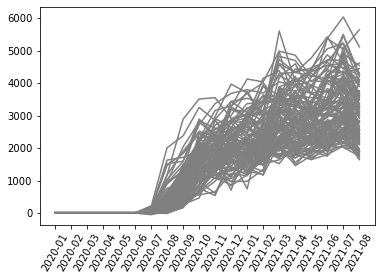

******************************
**********CLUSTER 0
******************************
Number of regions 218
Average sales 433.1110943575955
Forecast uncertainty 79.4082479288178


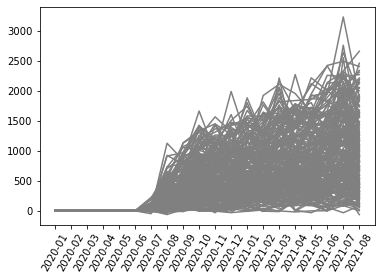

******************************
**********CLUSTER 1
******************************
Number of regions 64
Average sales 2998.6891305205536
Forecast uncertainty 229.36722826805777


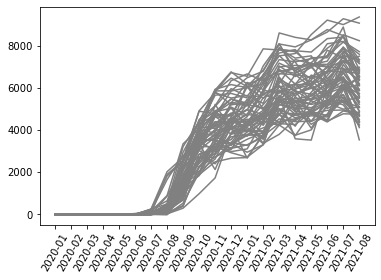

******************************
**********CLUSTER 3
******************************
Number of regions 7
Average sales 5812.249725050552
Forecast uncertainty 473.9661273170486


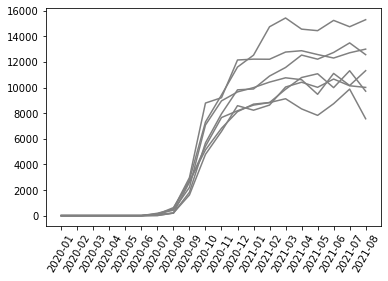

In [53]:
for cluster in cluster_data.cluster.unique():
    print('*'*30)
    print('*'*10 + 'CLUSTER', cluster)
    print('*'*30)
    current = cluster_data[cluster_data.cluster == cluster].reset_index(drop = True)
    print('Number of regions', current.shape[0])
    print('Average sales', current.drop(columns = ['region', 'brand','cluster']).mean(axis = 1).mean())
    print('Forecast uncertainty', current.merge(master.groupby(['region', 'brand']).uncertainty.mean().reset_index(), 
                                                how = 'left', on = ['region', 'brand']).uncertainty.mean() )
    for i in range(current.shape[0]):
        plt.plot(current.drop(columns = ['region', 'brand','cluster']).iloc[i], color = 'gray')
        plt.xticks(rotation=60)
    plt.show()

In [25]:
cluster_data[cluster_data.cluster == 1].reset_index(drop = True).iloc[0]

month
region      region_100
brand          brand_1
2020-01       0.247937
2020-02       0.247937
2020-03       0.247937
2020-04       0.080273
2020-05       0.080273
2020-06            0.0
2020-07      56.476854
2020-08      249.16675
2020-09    1040.590157
2020-10    1885.554209
2020-11    2491.201831
2020-12    2664.045091
2021-01    2696.696903
2021-02    3756.975468
2021-03    5515.723832
2021-04    4869.736442
2021-05    4841.455501
2021-06    5283.504127
2021-07    4988.475981
2021-08    5092.222687
cluster              1
Name: 0, dtype: object

In [21]:
cluster_data

month,region,brand,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
0,region_0,brand_1,0.247937,0.080273,0.080273,0.080273,0.080273,4.543376e-07,-4.391615,381.665183,1105.268783,1915.758637,2971.244269,3976.346600,3703.045206,2944.993821,5613.433488,4049.817210,4353.090447,4557.094236,4607.185382,3902.342993
1,region_0,brand_2,0.247937,0.080273,0.080273,0.080273,0.080273,4.543376e-07,-4.391615,557.838768,456.334066,475.650064,486.014153,973.745376,518.362081,555.819502,600.263398,530.453397,710.737137,682.227030,1261.105219,672.873253
2,region_1,brand_1,0.247937,0.247937,0.247937,0.080273,0.080273,4.543376e-07,119.577509,91.524662,595.515736,1264.370830,1656.104387,1442.009215,2022.239323,1461.374334,2092.988264,1562.651430,1922.663456,2537.077168,2588.507310,2816.261549
3,region_1,brand_2,0.247937,0.247937,0.247937,0.080273,0.080273,4.543376e-07,119.577509,64.466148,169.485616,637.172185,390.820625,351.899867,305.118684,203.956823,419.179966,601.980373,540.277997,438.980734,739.259928,434.925923
4,region_10,brand_1,0.247937,0.247937,0.247937,0.080273,0.080273,4.543376e-07,0.044608,32.399664,355.393952,658.970205,1094.279562,865.749539,1557.880477,1973.170157,2570.625565,2779.381865,2698.485261,2396.264256,2876.284550,3134.664421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,region_97,brand_2,0.247937,0.247937,0.247937,0.247937,0.247937,4.543376e-07,9.801211,171.985377,230.361293,612.441741,149.370617,229.542847,496.366624,113.067540,427.489241,486.461145,524.171485,517.710759,537.660264,398.115792
398,region_98,brand_1,0.247937,0.247937,0.247937,0.080273,0.080273,4.543376e-07,6.846780,-0.070641,450.448447,1780.691687,1392.205696,1602.525649,1644.190863,1600.216524,2991.930987,1462.068224,1764.995471,2164.153278,2847.195599,1754.003831
399,region_98,brand_2,0.247937,0.247937,0.247937,0.080273,0.080273,4.543376e-07,6.846780,247.085480,453.108515,691.914663,907.421186,610.469266,923.858910,723.698698,484.979536,840.064346,841.384939,916.410470,751.017732,986.831906
400,region_99,brand_1,0.247937,0.247937,0.247937,0.247937,0.247937,4.543376e-07,-0.718377,37.164048,248.476261,90.725691,566.962869,571.327829,453.757691,665.436230,550.258263,583.186819,1017.676044,1309.733172,966.057025,1075.625850
